### **Content License Agreement**

<font color='red'><b>**WARNING**</b></font> : 본 자료는 삼성 청년 SW아카데미의 컨텐츠 자산으로, 보안서약서에 의거하여 어떠한 사유로도 임의로 복사, 촬영, 녹음, 복제, 보관, 전송하거나 허가 받지 않은 저장매체를 이용한 보관, 제3자에게 누설, 공개 또는 사용하는 등의 무단 사용 및 불법 배포 시 법적 조치를 받을 수 있습니다.

### **Objectives**
1. 실습 개요
  - 웹 크롤링을 통한 데이터 수집
  - 제품 매뉴얼 PDF 데이터 변환 및 변환 시 주의사항
  - 변환 데이터 전처리
2. 실습 진행 목적 및 배경
  - 본 실습은 이론 강의에서 학습한 데이터 수집 이론을 실제로 적용하여 제품 매뉴얼 데이터를 검색하고, 웹사이트 구조를 분석하며, 데이터 수집 프로세스를 자동화하는 것을 목표로 합니다. 수집한 데이터를 정리하고 전처리하여, 챗봇 학습에 적합한 데이터셋을 생성하는 과정까지 수행합니다. 이를 통해 웹사이트 구조 분석, 데이터 수집과 처리, 그리고 학습 데이터셋 구축의 전반적인 과정을 체계적으로 이해하고 실습하는 것을 목적으로 합니다.
3. 실습 수행으로 얻어갈 수 있는 역량
  - 웹사이트 구조 분석
  - 웹 크롤링을 통한 데이터 수집 능력
  - PDF 데이터 변환 및 오류 처리
  - 변환 데이터 전처리 기술
4. 사용할 웹사이트: https://usermanual.wiki/search.php
  - 각종 매뉴얼을 검색할 수 있는 웹사이트
5. 실습 핵심 내용
  - 웹사이트 구조 분석, PDF 데이터 변환, 변환 데이터 전처리, 웹 크롤링을 통한 데이터 수집



### **Prerequisites**
- Colab 환경에서는 403 Forbidden 오류로 인해 웹 크롤링 작업이 제한될 수 있습니다. <br>따라서, 만일 Colab 환경에서 문제가 발생할 경우 로컬 환경에서 해당 코드를 실행하여 PDF 문서의 크롤링 및 전처리를 진행해 주시기 바랍니다.

In [ ]:
# # 구글드라이브 연동
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
DATA_DIR = '/Users/ijung-yun/SSAFY/DataTrack/Data'

In [2]:
!pip install pymupdf==1.24.14 markdownify==0.14.1
!pip install requests==2.32.3
!pip install bs4==0.0.2
!pip install selenium==4.27.1
!pip install python-dotenv==1.0.0

### Exercise Overview
- 웹 크롤링을 통한 데이터 수집
  - 웹사이트 구조 분석 및 전략 수립
  - Selenium WebDriver 설정 및 초기화
  - 광고 제거를 위한 함수
  - Selenium을 사용한 PDF 파일 URL 크롤링
  - requests를 사용하여 PDF 파일 다운로드
  - 메인 함수 정의 및 호출
- 제품 매뉴얼 PDF 데이터 변환 및 변환 시 주의사항
  - pumupdf와 markdownify를 사용해 JSON, HTML, MarkDown으로 변환
  - Upstage Document Parser API를 사용해 변환
- 변환 데이터 전처리
  - 텍스트 정제 함수 정의
  - pymupdf를 사용하여 pdf파일의 제품 이름 정보 추출
  - Upstage DP JSON 파일 예시

# 1. 웹 크롤링을 통한 데이터 수집

## 1.1 웹사이트 구조 분석 및 전략 수립

- [유저 매뉴얼 위키 사이트](https://usermanual.wiki/search.php)에 접속하여 웹사이트 구조 분석을 실행합니다.

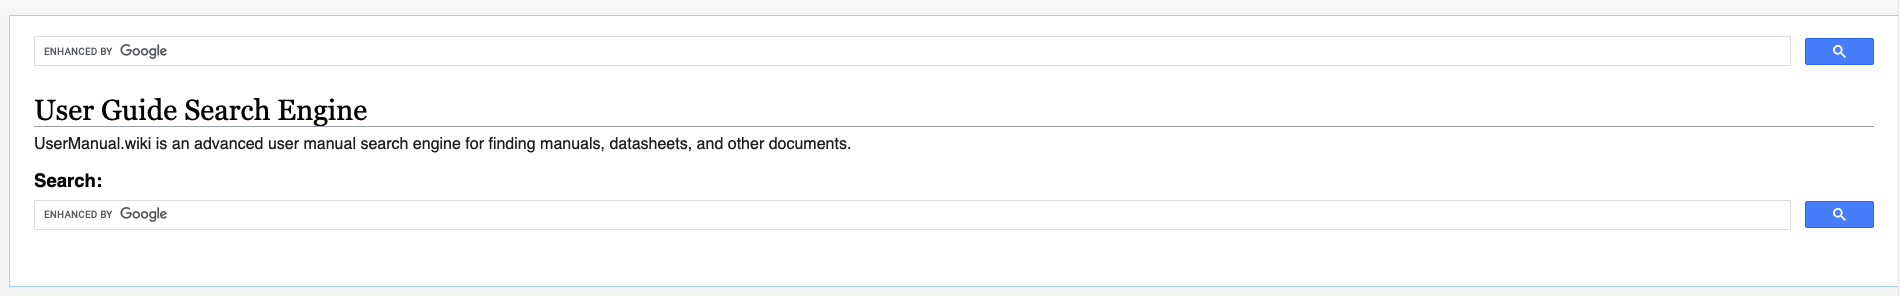

1. 검색창에 키워드를 입력하면 결과를 동적으로 표시하는 기능은 일반적으로 JavaScript와 API 호출을 통해 구현됩니다.
2. 서버에서 데이터를 실시간으로 가져오는 동적 웹사이트이기 때문에, requests와 beautifulsoup 대신 JavaScript 렌더링을 지원하는 selenium 라이브러리를 사용해야 합니다.

- 삼성 Galaxy 제품 매뉴얼 챗봇 데이터셋을 제작해야하기 때문에 `Samsung Galaxy`를 쿼리로 입력해줍니다.

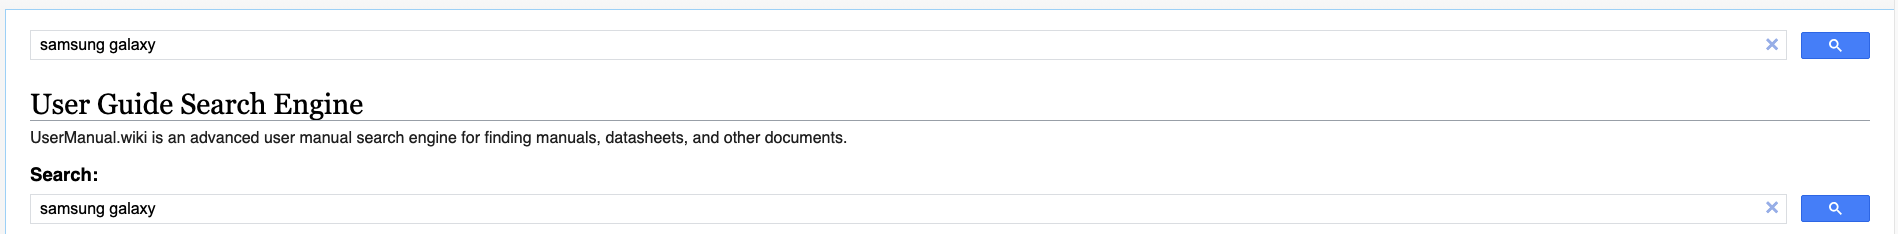

- Ctrl+Shift+C를 눌러 추출하고자하는 형식의 데이터의 HTML 특징을 분석합니다.

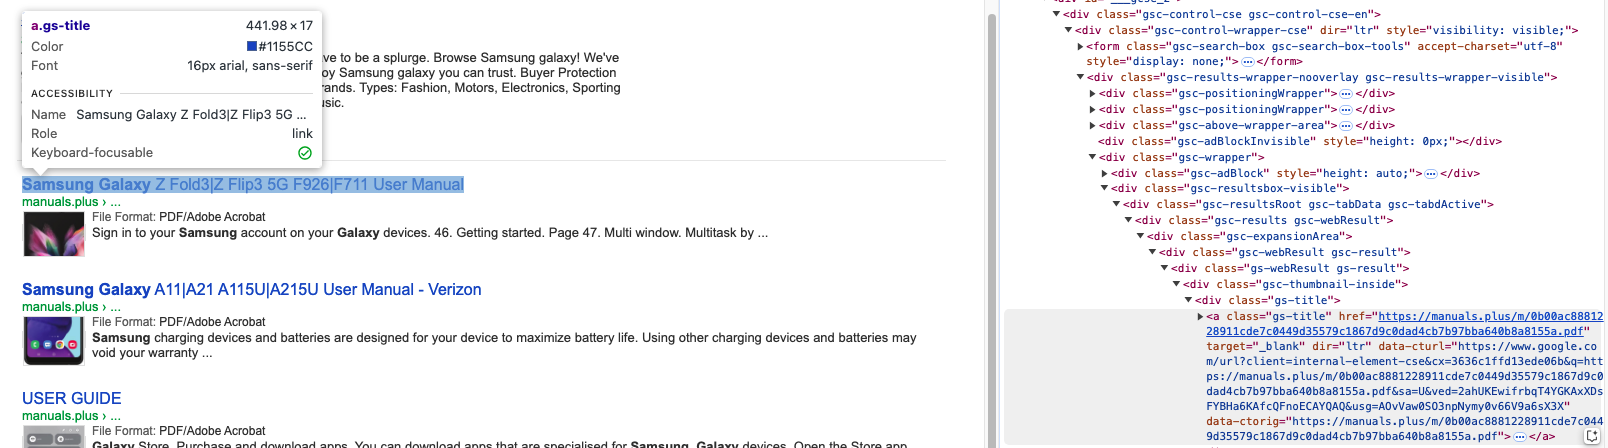

- `gs-title`이라는 class를 가진 `div`태그 안의 `a`태그가 해당 url을 가지고 올 수 있다는 분석을 할 수 있습니다.
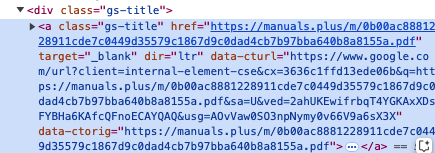

- 해당 `a` 태그의 `href` 속성을 사용해서 제품 매뉴얼의 링크를 크롤링할 수 있습니다.
- 또한, `pdf` 파일을 바로 다운받을 수 있도록 링크의 포맷이 `pdf`인 링크들로 한정합니다.

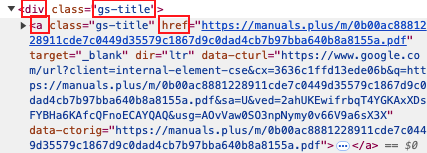

- 해당 `pdf`의 링크로 이동하여 `pdf`파일을 다운받는 코드를 통해 웹크롤링을 자동화 합니다.
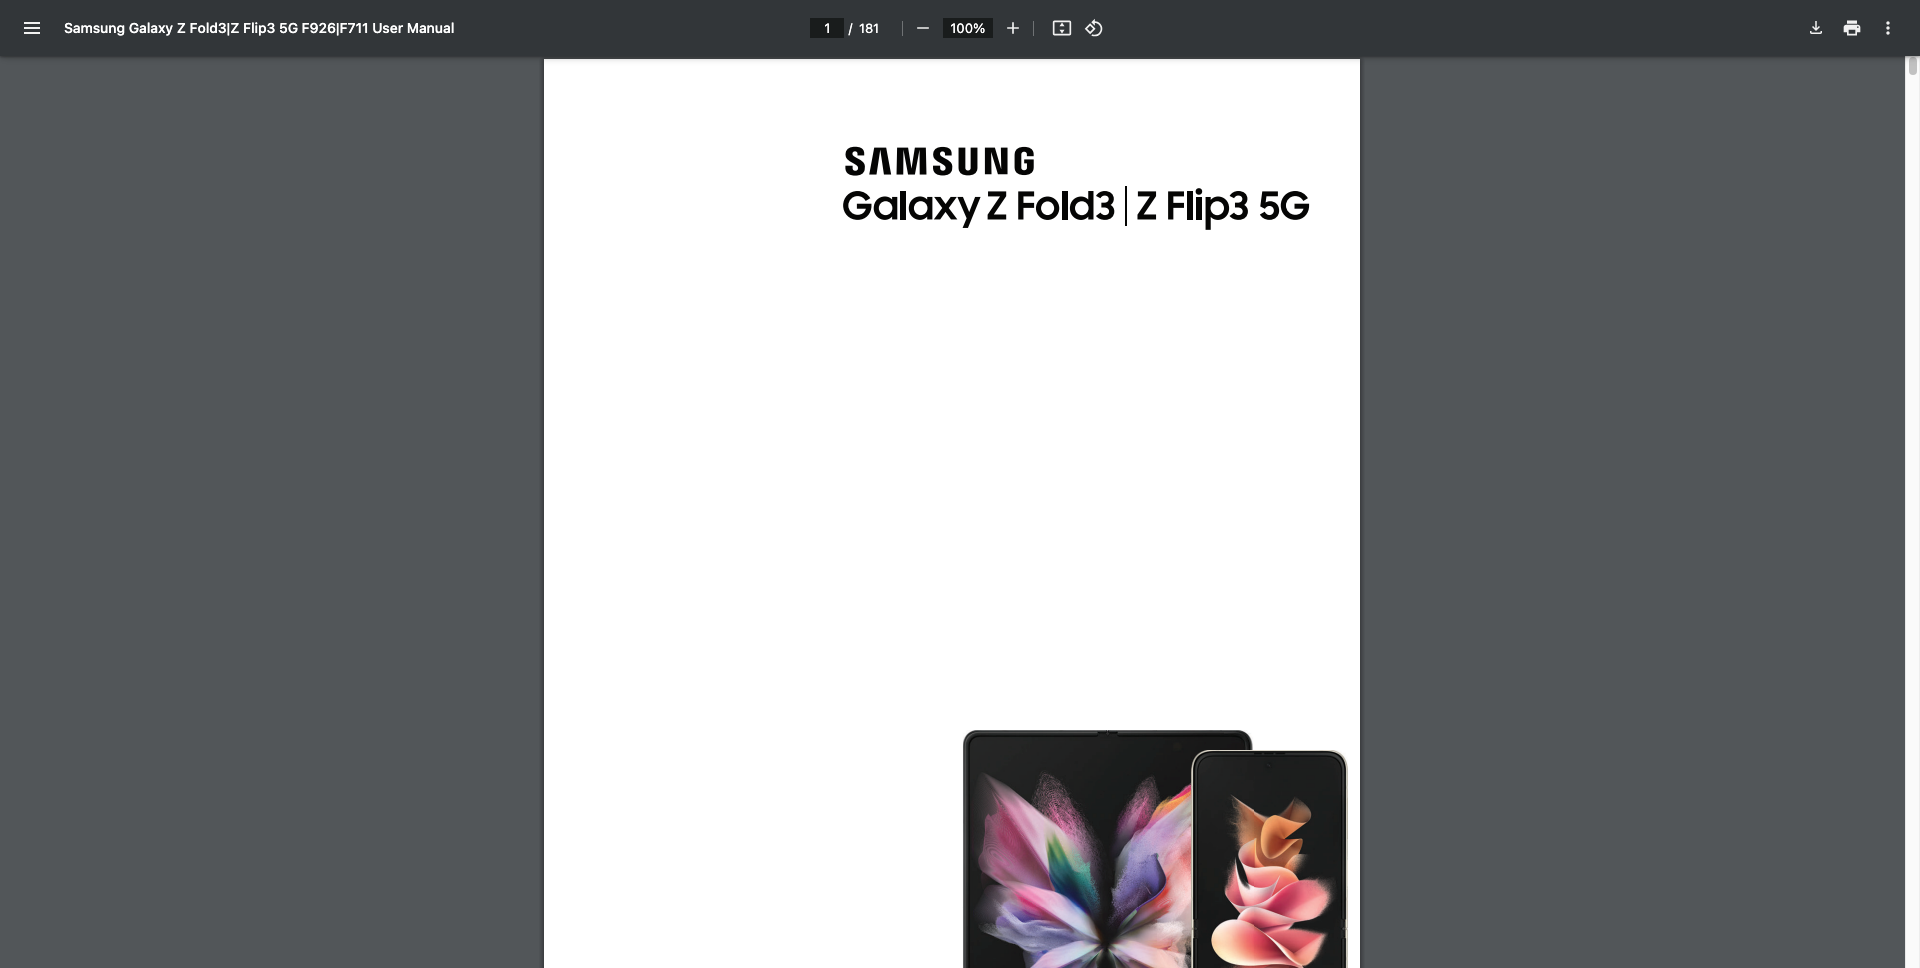

- 2페이지에도 제품 매뉴얼이 있으니 이번 실습에서는 최대 20개를 다운 받도록 합니다.
- Ctrl+Shift+C를 통해 2페이지로 가는 링크의 특징을 분석한 후 이동하여 10개의 제품 매뉴얼을 더 크롤링하는 계획까지 수립
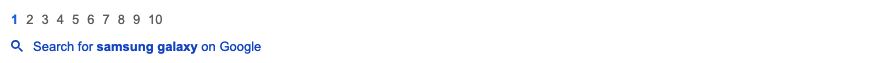

## 1.2 Import Libraries

### 1.2.1 Selenium 설치 확인

In [3]:
!python -c "import selenium; print(selenium.__version__)"

4.27.1


In [4]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
import os
import subprocess
import requests
from pathlib import Path

## 1.3 Selenium WebDriver 설정 및 초기화

In [5]:
def get_driver(output_dir):
    options = webdriver.ChromeOptions()

    # agent 정보
    options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36")
    # options.add_argument("--headless")  # 헤드리스 모드를 활성화하여 브라우저 UI를 표시하지 않고 백그라운드에서 실행 / 브라우저 실행 과정을 직접 확인하고 싶으시다면, 주석을 제거해 주세요.
    options.add_argument("--disable-gpu")  # GPU를 비활성화
    options.add_argument("--no-sandbox")  # 브라우저를 제한된 권한으로 실행하는 경우 샌드박스 모드를 비활성화 (Colab에서 필수)

    options.add_experimental_option('prefs', {
        "download.default_directory": output_dir, #Change default directory for downloads
        "download.prompt_for_download": False, #To auto download the file
        "download.directory_upgrade": True,
        "plugins.always_open_pdf_externally": True #It will not show PDF directly in chrome
        })

    driver = webdriver.Chrome(options=options)

    return driver

## 1.4 광고 제거를 위한 함수

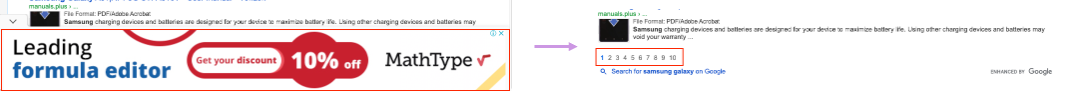

- 동적 웹사이트에서 Selenium을 사용해 크롤링할 시, 팝업 광고 때문에, 클릭하고자 하는 HTML element가 가려져 Selenium이 클릭하지 못하는 경우가 있습니다.
- 이번 실습에서는 광고 때문에 아래와 같이, 다음 페이지로 넘어가는 버튼을 누를 수 없어 광고의 CSS Selector를 모두 찾아 다음 함수를 사용해 제거합니다.

In [6]:
def remove_ads(driver):
    """광고를 숨기거나 DOM에서 완전히 제거하는 함수"""
    try:
        # 광고 요소 탐색
        ads = driver.find_elements(By.CSS_SELECTOR, "ins.adsbygoogle, #aswift_2_host, iframe#aswift_2")  # 해당 CSS Selector는 개발자 도구를 통해 광고를 가리키는 CSS Selector가 맞는지 확인합니다.
        for ad in ads:
            # DOM에서 광고 요소 제거
            driver.execute_script("arguments[0].parentNode.removeChild(arguments[0]);", ad)  # Selenium의 execute_script 메서드는 Python에서 JavaScript 코드를 실행할 수 있도록 합니다.
            print(f"Ad removed: {ad}")
    except Exception as e:
        print(f"Failed to remove ads: {e}")

## 1.5 Selenium을 사용한 PDF 파일 URL 크롤링

In [ ]:
def fetch_manual_links(driver, search_query, max_results=20):
    base_url = "https://usermanual.wiki/search.php?query="  # 'q'뒤에 검색하고자 하는 쿼리를 입력
    driver.get(base_url + search_query)  # WebDriver를 사용해 해당 검색 URL로 이동
    time.sleep(3)  # 페이지 로딩 대기

    # 링크 저장용 리스트
    manual_links = []

    page = 1  # 다음 페이지로 넘어가는 버튼 클릭 때마다 page 1씩 증가
    while len(manual_links) < max_results:  # 제품 메뉴얼 20개 수집

      results = driver.find_elements(By.CSS_SELECTOR, "#primary a[href$='.pdf']")

      for result in results:
        href = result.get_attribute('href')  # href attrbute값 추출
        if isinstance(href, str) and href.endswith('.pdf'):  # href 값이 정상적이고, pdf로 끝날경우 True 리턴
          if len(manual_links) < 20:  # 실습 영상에서는 제품 매뉴얼 하나만 다운 받는 코드였다면, 실습 코드에서는 20개 다운로드
            manual_links.append(href)
          else:
            break  # 갯수가 20개가 넘으면 while loop break

      remove_ads(driver)  # 다음 페이지로 넘어가는 버튼이 광고로 가려지는 경우 다음 페이지 버튼을 클릭할 수 없기에, 광고 제거
      time.sleep(3)

      page += 1  # 다음 페이지로 넘어가기 위해 page + 1
      try:
        next_button = driver.find_element(By.CSS_SELECTOR, f"div.gsc-cursor-page[aria-label='Page {page}']")  # 다음 페이지로 넘어가는 버튼의 element 찾기
        next_button.click()  # selenium을 사용해 다음 페이지 버튼 클릭
        time.sleep(3)
      except Exception as e:
        print(f'다음 페이지 버튼 클릭에 실패하였습니다(다음 페이지 버튼이 다음 페이지에 가려져 있을 확률이 높습니다).')

      manual_links = list(set(manual_links))  # 중복 링크 제거

    return manual_links

# 1.5.1-1 개선된 크롤링 코드

In [33]:
def fetch_manual_links(driver, search_query, max_results=20):
    base_url = "https://manuals.plus/deep-search?query="
    driver.get(base_url + search_query)
    time.sleep(3)

    manual_links = []
    visited = set()

    # 유연하게 doc-card 내부의 a 태그들 탐색
    anchors = driver.find_elements(By.CSS_SELECTOR, ".doc-card a[href]")
    detail_links = []

    for a in anchors:
        href = a.get_attribute("href")
        if href and href not in visited and "manuals.plus" in href:
            visited.add(href)
            detail_links.append(href)
            print(f"[DETAIL] {href}")

    print(f"[INFO] Found {len(detail_links)} detail links")

    # 상세 페이지 진입 후 PDF 추출
    for detail_url in detail_links:
        try:
            driver.get(detail_url)
            time.sleep(2)

            # 좀 더 유연하게 PDF a 태그 찾기
            pdf_elements = driver.find_elements(By.CSS_SELECTOR, "a[href$='.pdf']")
            for elem in pdf_elements:
                pdf_href = elem.get_attribute("href")
                if pdf_href and pdf_href not in manual_links:
                    manual_links.append(pdf_href)
                    print(f"✔ Found PDF: {pdf_href}")
                    break  # 하나만 찾고 넘어가기

            if len(manual_links) >= max_results:
                break

        except Exception as e:
            print(f"[ERROR] Failed to extract from {detail_url}: {e}")

    return manual_links


## 1.5.1 Google Search를 사용한 크롤링 (예시)
https://usermanual.wiki/search.php 사이트가 CloudFlare 522 에러를 반환하고 작동이 안 되는 경우가 종종 발생합니다. 이런 경우에는 삼성 제품 매뉴얼 PDF를 어떻게 크롤링 할 수 있을지 고민합니다.
`usermanual` 웹사이트가 작동하지 않는다면, 아래 주어진 예시 코드를 사용하여 다른 웹사이트에서 20개의 제품 매뉴얼 PDF를 크롤링 해오는 코드를 작성해 봅시다.

In [ ]:
def fetch_manual_links(driver, search_query, max_results=20):
    base_url = 'https://www.google.com/search?q='

    driver.get(base_url + search_query)  # WebDriver를 사용해 해당 검색 URL로 이동

    time.sleep(3)  # 페이지 로딩 대기

    # 링크 저장용 리스트
    manual_links = []

    # 검색 결과에서 링크 추출

    # "yuRUbf" 클래스를 가진 모든 div 요소를 리스트로 가져오기
    div_elements = driver.find_elements(By.CLASS_NAME, "yuRUbf")

    # 각 div에서 <a> 태그의 href 속성 가져오기
    for index, div_element in enumerate(div_elements):
        try:
            # 해당 div 내부의 <a> 태그 찾기
            a_tag = div_element.find_element(By.TAG_NAME, "a")

            # href 속성 값 가져오기
            href_value = a_tag.get_attribute("href")
            print(f"링크 {index + 1}: {href_value}")

            if href_value.endswith('pdf'):
                print(f'User Manual PDF 파일을 찾았습니다.')
                break

        except Exception as e:
            print(f"{index + 1}번째 div에서 <a> 태그를 찾을 수 없습니다: {e}")

    return [href_value]  # PDF 파일이 여러개라면 `List` 대신에 `Set`을 반환하여 중복 제거

## 1.6 `requests` 혹은 `selenium`을 사용하여 PDF 파일 다운로드

- 만일 둘 다 문제가 발생할 경우, <https://usermanual.wiki/> 웹사이트 자체가 접속이 안 되는 것은 아닌지 확인 필요

In [16]:
# selenium을 사용하는 코드
def download_pdf(pdf_links, output_dir):
    os.makedirs(output_dir, exist_ok=True)  # 저장 폴더 생성

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Referer": "https://usermanual.wiki/"
    }  # HTTP 요청의 일부로 User-Agent와 Referer을 추가해 요청이 승인되도록 함

    for idx, link in enumerate(pdf_links):
        print(f'idx, link: {idx, link}')
        file_name = os.path.join(output_dir, link.split("/")[-1])  # 파일명 추출
        try:
            print(f"{idx+1}th Downloading: {link}")
            response = requests.get(link, headers=headers, stream=True) # stream=True를 설정하면 서버로부터 받은 응답 데이터를 메모리에 한꺼번에 저장하지 않고, chunk 단위로 가져와 메모리를 효율적으로 사용

            if response.status_code == 200:  # 성공적으로 응답을 받았을 경우

                with open(file_name, "wb") as pdf_file:
                    for chunk in response.iter_content(chunk_size=1024):  # 파일 다운로드
                        pdf_file.write(chunk)

                print(f"Saved: {file_name}")
            else:  # 실패했을 경우
                print(f"Failed to download: {link} (Status code: {response.status_code})")

        except Exception as e:
            print(f"Error downloading {link}: {e}")


In [68]:
def download_pdf(pdf_links, output_dir, driver):
    os.makedirs(output_dir, exist_ok=True)  # 저장 폴더 생성

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
        "Referer": "https://usermanual.wiki/"
    }  # HTTP 요청의 일부로 User-Agent와 Referer을 추가해 요청이 승인되도록 함

    count = 0
    for idx, link in enumerate(pdf_links):
        file_name = os.path.join(output_dir, link.split("/")[-1])  # 파일명 추출
        try:
            print(f"{idx+1}th Downloading: {link}")
            

            driver = get_driver(output_dir=output_dir)
            driver.get(link)  # 자동으로 다운로드 받아짐. 스크린샷 확인해보면 blank 페이지가 로딩됨을 확인 가능
            count += 1
            time.sleep(3)

            # if count == 3:
            #   break

            print("Completed")


        except Exception as e:
            print(f"Error downloading {link}: {e}")

In [69]:
#  개선된 다운로드 코드
def download_pdf(pdf_links, output_dir, driver):
    os.makedirs(output_dir, exist_ok=True)

    for idx, link in enumerate(pdf_links):
        try:
            print(f"{idx+1}th Downloading: {link}")
            driver.get(link)
            time.sleep(3)
            print("Completed")
        except Exception as e:
            print(f"Error downloading {link}: {e}")


## 1.7 메인 함수 정의 및 호출

In [14]:
import os
print(os.getcwd())

/Users/ijung-yun/SSAFY/DataTrack


In [56]:
%%time

# 메인 함수 정의
def main():
    search_query = "Samsung+galaxy"

    download_dir = os.path.join(DATA_DIR, 'user_manual_pdf')
    driver = get_driver(output_dir=download_dir)

    try:  # 예외 처리

        # PDF 링크 추출
        pdf_links = fetch_manual_links(driver, search_query)
        print(f"Found {len(pdf_links)} PDF manuals:")

        # PDF 다운로드
        if pdf_links:
            download_pdf(pdf_links, output_dir=download_dir, driver=driver)
        else:
            print("No PDF links found.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        driver.quit()

if __name__ == "__main__":
    main()

[DETAIL] https://manuals.plus/samsung-galaxy/samsung-galaxy-a16-5g-smartphone-user-manual
[DETAIL] https://manuals.plus/samsung-galaxy/samsung-galaxy-sm-r390-smart-watch-user-manual
[DETAIL] https://manuals.plus/ifixit/samsung-galaxy-s6-battery-manual
[DETAIL] https://manuals.plus/charity-mobile/s23-samsung-galaxy-manual
[DETAIL] https://manuals.plus/m/d7025a051ac3b5561dcb268c6efcfde6345683a8691acbc9933dc9df2c29deef
[DETAIL] https://manuals.plus/m/f0d44ca5d4eb9266877887e18886293913df9f6a833341ee41baeaf12d0b3c22
[DETAIL] https://manuals.plus/m/6557987ab44311be6fc7f0418a6fabbca11d3d868089a4efaa0f90cc4396f7b6
[DETAIL] https://manuals.plus/m/6e1835a3192a1c8d16ba4d8361d4d6edd030c9628e174d79dfb87683cfe7418a
[DETAIL] https://manuals.plus/m/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83
[DETAIL] https://manuals.plus/m/379e9726daf2885feccbc1f24fa38bc55f591aaf0b9e1dc14370d56d0a142e31
[DETAIL] https://manuals.plus/m/288dce2785fedb780b981c9a96d1c740117f8186062a8732ab816ea52cf7184

- 위 코드를 실행하면 `user_manual_pdf` 라는 폴더 아래에 크롤링을 통해 다운 받은 user manual pdf 파일들이 저장됩니다.

# 2. 제품 매뉴얼 PDF 데이터 변환 및 변환 시 주의사항


## PDF 데이터 변환 시 주의사항
### 파일 구조와 형식의 다양성
- PDF는 일관된 구조를 가진 데이터 형식이 아니며, 텍스트, 이미지, 표 등 다양한 요소가 섞일 수 있음
- OCR(Optical Character Recognition)이 필요한 스캔본 PDF는 추출이 어렵고 품질이 낮을 수 있음

### 텍스트 인코딩 문제
- PDF에서 추출한 텍스트가 깨지거나 인코딩 문제로 인해 의미를 알 수 없는 문자가 포함될 수 있음
- 비영어권 언어(e.g. 한글, 중국어, 일본어 등)의 텍스트 처리 시 주의해야 함

### 레이아웃 유지
- 표, 도형 그래프가 포함된 문서의 경우 데이터가 누락될 가능성이 큼
- 이미지로 포함된 데이터는 별도의 OCR 도구를 사용하여 텍스트로 변환해야 함

### Parser의 성능에 따라 변환 결과 품질이 달라질 수 있음

### 저작권 및 법적 문제
- PDF 문서가 저작원 보호를 받는 경우, 데이터를 변환 및 사용하는 것이 법적 문제를 초래할 수 있으므로 사전 확인 필수

## 2.1 `pymupdf`와 `markdownify`를 사용해 `JSON`, `HTML`, `MarkDown`으로 변환

### 2.1-1 Library Import & PDF 경로 설정

In [57]:
import fitz  # PyMuPDF의 모듈 이름: PDF와 같은 문서 파일을 읽고 처리할 수 있게 해줌
import json  # JSON 데이터를 파싱하거나 생성하는데 사용
from markdownify import markdownify as md
from pathlib import Path
import os

### 2.1-2 제품 매뉴얼 데이터를 HTML로 변환

In [58]:
def pdf_to_html(pdf_path, output_html_path):
    doc = fitz.open(pdf_path)

    with open(output_html_path, 'w', encoding='utf-8') as html_file:

        for page_num in range(len(doc)):

            page = doc[page_num]
            html_content = page.get_text("html")  # PDF 페이지를 HTML 형식으로 변환
            html_file.write(html_content)

    print(f"PDF가 HTML로 저장되었습니다: {output_html_path}")

In [59]:
save_path = os.path.join(DATA_DIR, 'parsed_data/htmls')
pdf_path = os.path.join(DATA_DIR, 'user_manual_pdf')
os.makedirs(save_path, exist_ok=True)  # 폴더가 존재하지 않을 경우 폴더 생성

for pdf_file in Path(pdf_path).glob('*.pdf'):
  output_html_path = save_path / Path(f'{pdf_file.stem}.html')  # Path 객체 사용
  pdf_to_html(pdf_file, output_html_path)

PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/1134a57decfa283c6d37a8665e402131ca30797f662ced6302e8a58d81b8c5dd.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/c40e36159f9686078d404fbba79a2f4e6599f9121f28a8984b34eddc33ce83cc.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/288dce2785fedb780b981c9a96d1c740117f8186062a8732ab816ea52cf71844.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/samsung-galaxy-s6-battery-manual.html
PDF가 HTML로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/htmls/6e1835a3192a1c8d16ba4d8361d4d6edd030c9628e174d79dfb87683cfe7418a.html
PDF가 HTML로

### 2.1-3 제품 매뉴얼 데이터를 JSON 데이터로 변환

In [60]:
def pdf_to_json(pdf_path, output_json_path):

    doc = fitz.open(pdf_path)
    pdf_data = {}

    for page_num in range(len(doc)):
        page = doc[page_num]
        text = page.get_text("text")  # PDF 텍스트 추출
        pdf_data[f"Page {page_num + 1}"] = text.strip()

    with open(output_json_path, 'w', encoding='utf-8') as json_file:
        json.dump(pdf_data, json_file, ensure_ascii=False, indent=4)

    print(f"PDF가 JSON으로 저장되었습니다: {output_json_path}")

In [61]:
save_path = os.path.join(DATA_DIR, 'parsed_data/jsons')
pdf_path = os.path.join(DATA_DIR, 'user_manual_pdf')
os.makedirs(save_path, exist_ok=True)  # 폴더가 존재하지 않을 경우 폴더 생성

for pdf_file in Path(pdf_path).glob('*.pdf'):
  output_json_path = save_path / Path(f'{pdf_file.stem}.json')  # Path 객체 사용
  pdf_to_json(pdf_file, output_json_path)

PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/1134a57decfa283c6d37a8665e402131ca30797f662ced6302e8a58d81b8c5dd.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/c40e36159f9686078d404fbba79a2f4e6599f9121f28a8984b34eddc33ce83cc.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/288dce2785fedb780b981c9a96d1c740117f8186062a8732ab816ea52cf71844.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/samsung-galaxy-s6-battery-manual.json
PDF가 JSON으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/jsons/6e1835a3192a1c8d16ba4d8361d4d6edd030c9628e174d79dfb87683cfe7418a.json
PDF

### 2.1-4 제품 매뉴얼 데이터를 MarkDown 형식으로 변환


In [62]:
def pdf_to_markdown(pdf_path, output_md_path):

    doc = fitz.open(pdf_path)
    with open(output_md_path, 'w', encoding='utf-8') as md_file:

        for page_num in range(len(doc)):

            page = doc[page_num]
            html_content = page.get_text("html")  # PDF 내용을 HTML로 추출
            md_content = md(html_content)  # HTML을 Markdown으로 변환
            md_file.write(f"### Page {page_num + 1}\n\n")
            md_file.write(md_content + "\n\n")

    print(f"PDF가 Markdown으로 저장되었습니다: {output_md_path}")

In [63]:
save_path = os.path.join(DATA_DIR, 'parsed_data/mds')
pdf_path = os.path.join(DATA_DIR, 'user_manual_pdf')
os.makedirs(save_path, exist_ok=True)  # 폴더가 존재하지 않을 경우 폴더 생성

for pdf_file in Path(pdf_path).glob('*.pdf'):
  output_md_path = save_path / Path(f'{pdf_file.stem}.md')  # Path 객체 사용
  pdf_to_markdown(pdf_file, output_md_path)

PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/1134a57decfa283c6d37a8665e402131ca30797f662ced6302e8a58d81b8c5dd.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/c40e36159f9686078d404fbba79a2f4e6599f9121f28a8984b34eddc33ce83cc.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/288dce2785fedb780b981c9a96d1c740117f8186062a8732ab816ea52cf71844.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/samsung-galaxy-s6-battery-manual.md
PDF가 Markdown으로 저장되었습니다: /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/mds/6e1835a3192a1c8d16ba4d8361d4d6edd030c9628e174d79dfb87683cfe7418a.md
PDF

## 2.2 Upstage Document Parser API를 사용해 변환

참고: [Upstage Document Parser API](https://console.upstage.ai/docs/capabilities/document-parse?utm_medium=hero-button&utm_source=web-blog&utm_campaign=dp-launch-mkt)

### 2.2-1 Library Import & PDF 경로 설정

In [64]:
import requests
import os
from pathlib import Path
import json
# from google.colab import userdata  # Upstage API Load를 위한 Google Colab 자체 라이브러리

In [65]:
save_fp = os.path.join(DATA_DIR, 'parsed_data/upstage_dp')
pdf_path = os.path.join(DATA_DIR, 'user_manual_pdf')
os.makedirs(save_fp, exist_ok=True)  # 폴더가 존재하지 않을 경우 폴더 생성

### 2.2-2 Upstage API Key 설정

#### 아래 셀을 실행하기 전에 발급 받은 Upstage API Key를 Colab에 설정

- KEY 로드 방법은 아래 글 참고
> 참고: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0

In [66]:
api_key = "up_JS6nndROlwPvo1upTDEGE0iJVAkZK"

### 2.2-3 Upstage 엔드포인트로 PDF 파일과 함께 요청 후 응답 받기

In [67]:
data = {
    "output_formats": "['html', 'text', 'markdown']",  # 원하는 출력 형식 설정 (HTML, Text, Markdown)
    "base64_encoding": "['table']",                   # 테이블 데이터를 Base64로 인코딩
    "ocr": "force",                                   # OCR 강제 사용 설정
    "coordinates": "true",                            # 결과에 좌표 정보 포함
}  # REST API 요청에 포함할 데이터

count = 0
url = "https://api.upstage.ai/v1/document-ai/document-parse"  # REST API의 엔드포인트 URL
headers = {"Authorization": f"Bearer {api_key}"}  # 인증을 위한 API 키 포함

for manual_pdf in Path(pdf_path).glob('*.pdf'):
  filename = manual_pdf.name

  files = {"document": open(manual_pdf, "rb")}

  response = requests.post(url, headers=headers, files=files, data=data)  # POST 요청 전송

  if response.status_code == 200:
    response_data = response.json()
  else:
    print(f"Error: {response.status_code}, {response.text}")

  temp_fp = Path(save_fp) / Path(f'{manual_pdf.stem}.json')  # 결과를 저장할 JSON 파일 경로 설정
  with open(temp_fp, "w", encoding="utf-8") as json_file:
      print(f'Writing parsed {manual_pdf} file to JSON.')
      json.dump(response_data, json_file, ensure_ascii=False, indent=4)
      print(f'{manual_pdf} file saved as {temp_fp}')


Writing parsed /Users/ijung-yun/SSAFY/DataTrack/Data/user_manual_pdf/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.pdf file to JSON.
/Users/ijung-yun/SSAFY/DataTrack/Data/user_manual_pdf/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.pdf file saved as /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/upstage_dp/8b855928937e88f6a389bcbb8b16f8d6517f77d1ea704cf783268a649cba5e9c.json
Writing parsed /Users/ijung-yun/SSAFY/DataTrack/Data/user_manual_pdf/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.pdf file to JSON.
/Users/ijung-yun/SSAFY/DataTrack/Data/user_manual_pdf/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.pdf file saved as /Users/ijung-yun/SSAFY/DataTrack/Data/parsed_data/upstage_dp/036c7547e7d612de44978341e5b1c47d192ef20030973e852bf80a08e51b3b83.json
Writing parsed /Users/ijung-yun/SSAFY/DataTrack/Data/user_manual_pdf/1134a57decfa283c6d37a8665e402131ca30797f662ced6302e8a58d81b8c5dd.pdf file to JSON.
/Users/i

### 2.2-4 Upstage Document Parser 사용시 주의 사항
- Document Parser API는 다음과 같은 RPS(Request Per Second)가 존재합니다. ([참고 링크](https://console.upstage.ai/docs/resources/rate-limits#document-parse))
  - RPS란 1초에 보낼수 있는 Request 수를 의미합니다.
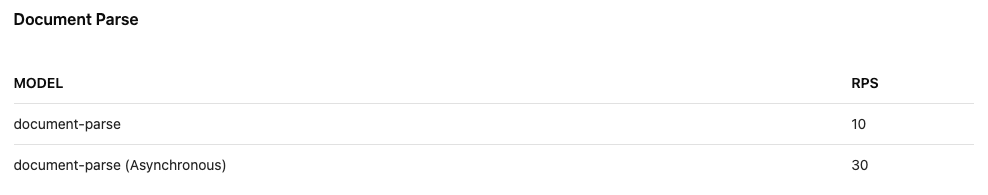
- Upstage Document Parser API 공식 문서는 [해당 링크](https://console.upstage.ai/docs/getting-started/overview)를 참고 부탁드립니다.
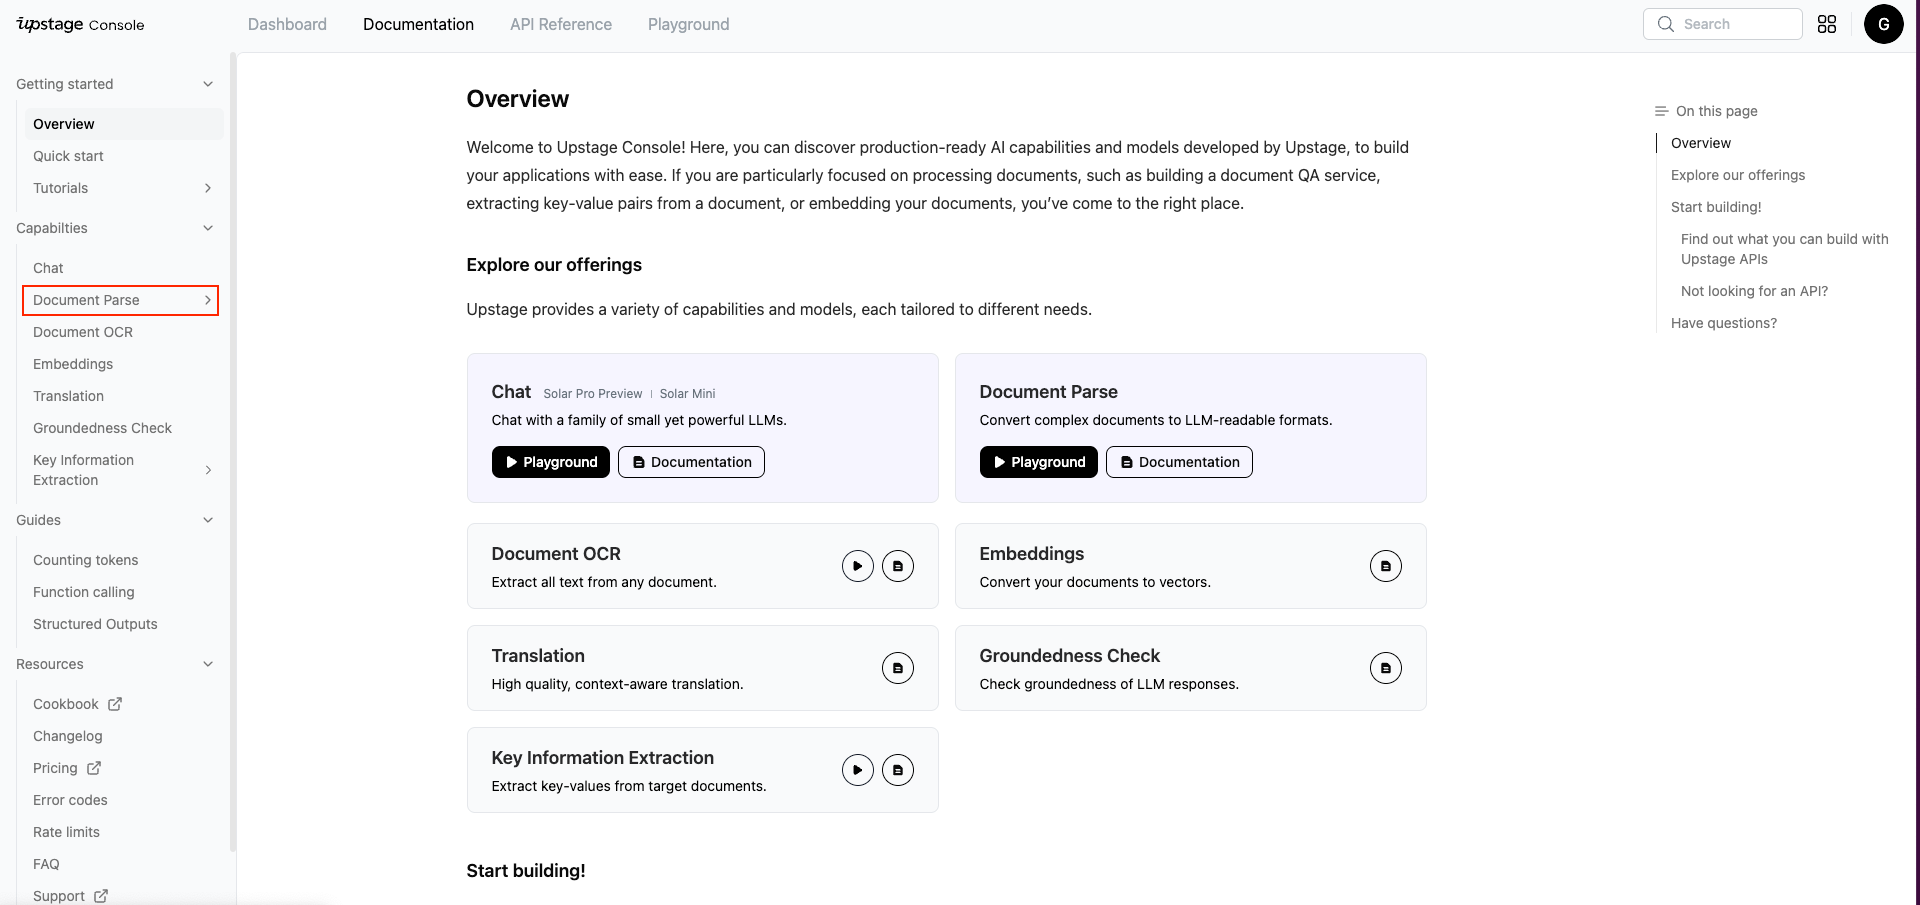

# 3. 변환 데이터 전처리

## 3.1 Import Libraries

In [70]:
import json
import re
from pathlib import Path
import json
import fitz

## 3.2 텍스트 정제 함수 정의

Upstage Document Parser를 통해 Parsing된 Markdown데이터에서 마크다운 문법을 제거하여 전처리 실행

In [71]:
def remove_markdown_syntax(markdown_text):

    text = re.sub(r'#+\s', '', markdown_text)

    text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
    text = re.sub(r'\*(.*?)\*', r'\1', text)
    text = re.sub(r'__(.*?)__', r'\1', text)
    text = re.sub(r'_(.*?)_', r'\1', text)

    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)

    text = re.sub(r'!\[.*?\]\(.*?\)', '', text)

    text = re.sub(r'`(.*?)`', r'\1', text)

    text = re.sub(r'```.*?```', '', text, flags=re.S)

    text = re.sub(r'\n[-*]{3,}\n', '\n', text)

    text = re.sub(r'^\s*>', '', text, flags=re.M)

    text = re.sub(r'^[\*\-]\s', '', text, flags=re.M)

    text = re.sub(r'^\d+\.\s', '', text, flags=re.M)

    text = re.sub(r'\n{2,}', '\n', text)
    text = text.strip()

    return text

## 3.3 `pympdf`를 사용하여 pdf파일의 제품 이름 정보 추출

In [72]:
def get_pdf_metadata(pdf_path):
    # PDF 열기
    document = fitz.open(pdf_path)

    # 메타데이터 추출
    metadata = document.metadata

    # 파일 닫기
    document.close()

    return metadata

## 3.4 Upstage DP JSON 파일 예시

코드 작동 방식 설명
1.	`PyMuPDF` 라이브러리를 사용해 메타데이터로 `product_name` 추출
2.	`Upstage Doc Parser`로 가져온 `User Manual PDF`의 `Markdown` 콘텐츠를 위에서 정의한 함수로 전처리
3.	전처리한 내용을 리스트 형태로 `content`에 저장
4.	`flag` 키에 `product_name`이 존재할 경우 `true`, 없으면 `false`로 설정
5.	위 1,2,3,4의 과정을 모든 `User Manual PDF` 처리 후 결과를 `jsonl`형태로 저장

하나의 `User Manual Pdf`파일 저장 예시

e.g. `processed_data_full.jsonl`
```
{
  "title": {Product name},
  "content": ["preprocessed markdown content1", "preprocessed markdown content2", "preprocessed markdown content3"],
  "flag": true / false
}
```



In [73]:
outfile = Path(os.path.join(DATA_DIR, 'processed_data_full.jsonl'))
in_fp = Path(os.path.join(DATA_DIR, 'parsed_data/upstage_dp'))
pdf_dir = Path(os.path.join(DATA_DIR, 'user_manual_pdf'))

with open(outfile, 'w', encoding='utf-8') as outfile:
  for parsed_json in in_fp.glob('*.json'):

    #  제품 이름 얻는 작업
    filename = parsed_json.stem
    pdf_filename = f'{filename}.pdf'
    pdf_path = pdf_dir / pdf_filename
    product_name = get_pdf_metadata(pdf_path)['title']  # 제품 이름 얻기 / 제품 이름이 비어있을 경우 empty string

    # Parsed된 Markdown content 얻기
    parsed_markdown_content_list = []
    with open(parsed_json, 'r', encoding='utf-8') as f:
      parsed_markdown = json.load(f)

    for element in parsed_markdown['elements']:
      content = element['content']['markdown']
      parsed_markdown_content_list.append(remove_markdown_syntax(content))

    product_jsonl = {'product_name': product_name, 'content': parsed_markdown_content_list, 'flag': True if len(product_name) else False}
    outfile.write(json.dumps(product_jsonl, ensure_ascii=False) + '\n')

print(f'parsed markdown jsonl file has been saved to {outfile.name}')

parsed markdown jsonl file has been saved to /Users/ijung-yun/SSAFY/DataTrack/Data/processed_data_full.jsonl


## 4.0 로컬 환경에 `processed_data_full.jsonl` 파일 다운로드

In [74]:
from google.colab import files

# 다운로드 받을 파일 경로
file_path = os.path.join(DATA_DIR, 'processed_data_full.jsonl')

# Download the file
files.download(file_path)

ModuleNotFoundError: No module named 'google'